# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


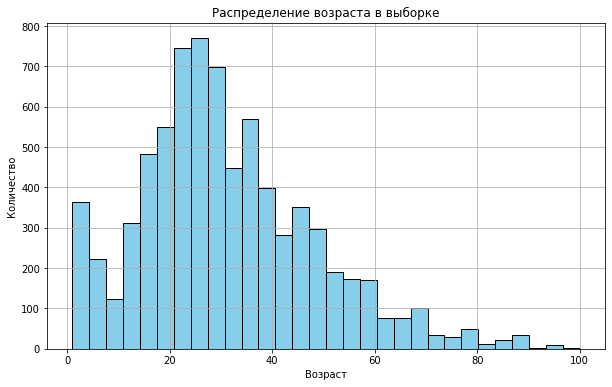

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

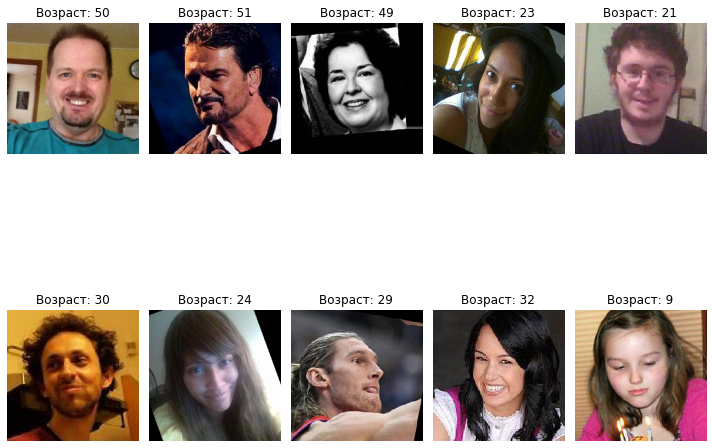

In [4]:
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    img, label = train_gen_flow.next()
    ax.imshow(img[0])
    ax.set_title(f'Возраст: {label[0]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Вывод после знакомства с данными.
* Размера датасета достаточно большой, однако основная масса людей на снимках принадлежит диапозону от 20 до 40 лет    
* Некотрые фото скрывают часть лица, что может отразиться на качестве обучения  
* Так же имеются фотографии плохого качества и ч/б фотографии
* В ходе иследования немного лучший результат дала горизонтальная аугментация


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    data = pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.2, rescale = 1./255)
    gen_flow = datagen.flow_from_dataframe(
                        dataframe = data,
                        directory = '/datasets/faces/final_files/',
                        x_col = 'file_name',
                        y_col = 'real_age',
                        target_size = (224, 224),
                        batch_size = 32,
                        class_mode = 'raw',
                        subset = 'training',
                        seed = 42, horizontal_flip=True

                        )
    return gen_flow

def load_test(path):
    data = pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.2, rescale = 1./255)
    gen_flow = datagen.flow_from_dataframe(
                        dataframe = data,
                        directory = '/datasets/faces/final_files/',
                        x_col = 'file_name',
                        y_col = 'real_age',
                        target_size = (224, 224),
                        batch_size = 32,
                        class_mode = 'raw',
                        subset = 'validation',
                        seed = 42
                        )
    return gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, epochs=5, steps_per_epoch=None, validation_steps=None, batch_size=None):
    steps_per_epoch = len(train_data) if steps_per_epoch else None
    validation_steps = len(test_data) if validation_steps else None
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 190 steps, validate for 48 steps
Epoch 1/5
2023-10-03 12:22:17.731079: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-03 12:22:18.089145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 50s - loss: 224.5391 - mae: 10.8724 - val_loss: 968.5292 - val_mae: 26.2398
Epoch 2/5
190/190 - 40s - loss: 57.7695 - mae: 5.7842 - val_loss: 827.0711 - val_mae: 23.5936
Epoch 3/5
190/190 - 41s - loss: 28.9585 - mae: 4.1583 - val_loss: 224.8269 - val_mae: 11.0063
Epoch 4/5
190/190 - 44s - loss: 19.7818 - mae: 3.4109 - val_loss: 118.4386 - val_mae: 8.4016
Epoch 5/5
190/190 - 49s - loss: 15.4161 - mae: 3.0396 - val_loss: 90.9139 - val_mae: 7.4251
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 90.9139 - mae: 7.4251
Test MAE: 7.4251
```
Вывод: Обучили модель с помощью ResNet50 с оптимизатором adam при шаге lr=0.0001. Обучались на 5 эпохах. На тестовой выборке получили MAE=7.4251, что является хорошим результатом, так как по условию проекта MAE модели не должно быть больше 8.


## Анализ обученной модели

- В проекте использовали архитектуру **RESNET50** с 50 слоями.
- Модель обучалась **5 эпохами**, размер батчей **32**, оптимизатор выбран **ADAM** c шагом **lr=0.0001**.
        - Многие фото скрывают часть лица, что естественно не может не отразиться на качестве обучения модели.
        - Размер датасета в принципе большой, но неравномерный.
            - Основная масса людей на снимках принадлежит диапазону от 20 до 40 лет, что тоже будет влиять на качество моделей.
            - До 20 лет и больше 40 не хватает объектов, было бы лучше, если бы возраст был распределен равномерно и фото были лучшего качества.
- Чтобы написать общий вывод, в GPU-тренажёре было протестировано несколько вариантов моделей.
    - Была использована аугментация **horizontal_flip**, **vertical_flip** и **rotation_range**.
    - При помощи перебора выяснилось, что немного лучший результат дает горизонтальная аугментация.
    48/48 - 9s - loss: 90.9139 - mae: 7.4251
Test MAE: 7.4251